### Building a cat dog classifier using Custom Dataset implementation

**Date:** 1/11/2021  
**Author:** Murad Popattia

In [2]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import Image
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

Reference for loc iloc difference:  
https://towardsdatascience.com/how-to-use-loc-and-iloc-for-selecting-data-in-pandas-bd09cb4c3d79

### Visualizing the csv

In [57]:
df = pd.read_csv("../datasets/cats_and_dogs/cats_and_dogs.csv")
df.head()

,Animal,Label
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


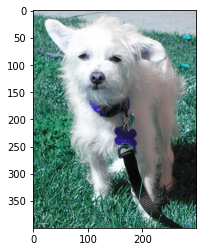

In [43]:
import matplotlib.pyplot as plt

img = cv2.imread("../datasets/cats_and_dogs/dog.12499.jpg")

plt.imshow(img)

Need for shifting color when reading image with cv2

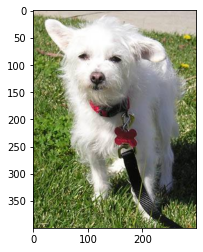

In [45]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [54]:
img[0][0], cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[0][0]

(array([191, 203, 215], dtype=uint8), array([215, 203, 191], dtype=uint8))

### Creating the dataset

In [3]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transforms=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir # where the images are stored
        self.transforms = transforms
        
    def __len__(self):
        return len(self.annotations) # 25000 50% cats 50% dogs
        
    def __getitem__(self, index):
        # index refers to poisiton in row, and 0 means 1st column etc.
        # equivalent loc -> df.loc[index, 'Animal']
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        
        # reading image and label
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform only works on PIL images
        img = Image.open(img_path)

        y_label = torch.tensor(self.annotations.iloc[index, 1])
        
        # apply transformations if available
        if self.transforms:
            img = self.transforms(img)
            
        return (img, y_label) # return as a tuple

In [4]:
# define the transformations
transformations = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = CatsAndDogsDataset(csv_file="../datasets/cats_and_dogs/cats_and_dogs.csv",
                            root_dir="../datasets/cats_and_dogs/images",
                            transforms=transformations)

### Preparing train test splits

In [5]:
# hyper params
num_classes = 2
lr = 0.001
batch_size = 64
num_epochs = 5

In [6]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [20000,5000])

# calling dataloader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [10]:
# lets import a pretrained model

model = torchvision.models.googlenet(pretrained=True)
for params in model.parameters():
    params.requires_grad = False

In [11]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [13]:
model = model.to(device)

In [15]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# replacing with the number of classes that we have
model.aux1 = Identity()
model.aux2 = Identity()
model.fc = nn.Linear(1024, 2)

In [16]:
from torchinfo import summary

model = model.to(device)
summary(model, input_size=(len(train_loader), 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                --                        --
├─BasicConv2d: 1-1                       [313, 64, 112, 112]       --
│    └─Conv2d: 2-1                       [313, 64, 112, 112]       (9,408)
│    └─BatchNorm2d: 2-2                  [313, 64, 112, 112]       (128)
├─MaxPool2d: 1-2                         [313, 64, 56, 56]         --
├─BasicConv2d: 1-3                       [313, 64, 56, 56]         --
│    └─Conv2d: 2-3                       [313, 64, 56, 56]         (4,096)
│    └─BatchNorm2d: 2-4                  [313, 64, 56, 56]         (128)
├─BasicConv2d: 1-4                       [313, 192, 56, 56]        --
│    └─Conv2d: 2-5                       [313, 192, 56, 56]        (110,592)
│    └─BatchNorm2d: 2-6                  [313, 192, 56, 56]        (384)
├─MaxPool2d: 1-5                         [313, 192, 28, 28]        --
├─Inception: 1-6                         [313, 256, 28, 28]

In [17]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
for epoch in range(num_epochs):  # 1 epoch means the model has seen all the images
    total_loss = 0
    counter = 0 
    
    n_batches = len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}')
    pbar = tf.keras.utils.Progbar(target=n_batches)
    
    # Training
    model.train()
    
    for idx, (data, target) in enumerate(train_loader):  # enumerating to see the batch idx
        
        # get data to cuda if possible
        data = data.to(device)
        target = target.to(device)
        
        # foward
        scores = model(data)  
        loss = criterion(scores, target)
        total_loss += loss
        
        pbar.update(idx, values=[("loss",loss.item())])
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent step
        optimizer.step()
        
        # increment for every batch
        counter += 1
        
    # for every epoch calculate test loss
    # validation
    model.eval()
    
    for idx, (data, target) in enumerate(test_loader):
        with torch.no_grad(): # no computation for gradients
            # get data to cuda
            data = data.to(device)
            target = target.to(device)

            scores = model(data)
            loss = criterion(scores, target)
            
            pbar.update(idx, values=[("validation loss",loss.item())])
    
    pbar.update(n_batches, values=None)

Epoch 1/5
313/313 [==============================] - 200s 126ms/step - loss: 0.1475 - validation loss: 0.0792
Epoch 2/5
313/313 [==============================] - 122s 75ms/step - loss: 0.0895 - validation loss: 0.0622
Epoch 3/5
313/313 [==============================] - 121s 75ms/step - loss: 0.0831 - validation loss: 0.0575
Epoch 4/5
  0/313 [..............................] - ETA: 0s - loss: 0.0773

KeyboardInterrupt: 

In [26]:
from tqdm import tqdm

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    output_gt = []
    output_pred = []
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1) # .max() return max value and indices
            
            output_gt.extend(y.cpu().numpy())
            output_pred.extend(predictions.cpu().numpy())

        print(f'Precision: {precision_score(output_gt, output_pred, average="micro")}')
        print(f'Recall: {recall_score(output_gt, output_pred, average="micro")}')
        print(f'F1_score: {f1_score(output_gt, output_pred, average="micro")}')

In [27]:
check_accuracy(train_loader, model)

100%|██████████| 313/313 [01:38<00:00,  3.19it/s]


Precision: 0.979
Recall: 0.979
F1_score: 0.979


In [28]:
check_accuracy(test_loader, model)

100%|██████████| 79/79 [00:24<00:00,  3.17it/s]

Precision: 0.978
Recall: 0.978
F1_score: 0.978


### Predictions from the model

tensor([0])


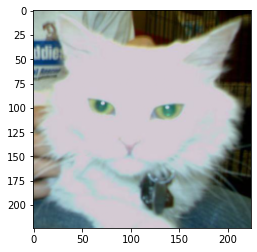

In [47]:
img, label = test_dataset[2]

plt.imshow(img.permute(1,2,0))

model = model.cpu()
scores = model(img.unsqueeze(0))
_, predictions = scores.max(1) # .max() return max value and indices

print(predictions)

tensor([1])


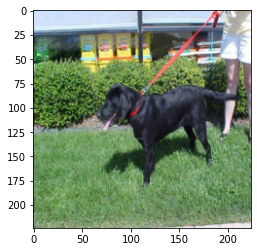

In [46]:
img, label = test_dataset[10]

plt.imshow(img.permute(1,2,0))

model = model.cpu()
scores = model(img.unsqueeze(0))
_, predictions = scores.max(1) # .max() return max value and indices

print(predictions)